In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings as wr
wr.filterwarnings('ignore')

In [3]:
loan = pd.read_csv('loan.csv') #Reading the data into DataFrame.

In [4]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [5]:
total = loan['id'].count()
total

39717

# Data Cleaning

Checking for Nulls and dropping the columns with Nulls as more than 50% of data.

In [6]:
loan.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [7]:
nulls = (loan.isnull().sum()/total)*100
nulls_index = nulls[nulls>50].index

In [8]:
loan.drop(columns = nulls_index, inplace = True)

Some columns have only one value, which makes them irrelevant for exploratory data analysis. hence, we can drop them. And ‘url’ does not provide any useful insights for analysis

In [9]:
loan.drop(['collections_12_mths_ex_med', 'policy_code', 'delinq_amnt','initial_list_status','url',
       'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths','tax_liens'], axis =1, inplace = True)

In [10]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.0


Upon further inspection we found that home_ownership column has 'NONE' values

In [11]:
loan['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE'], dtype=object)

In [12]:
loan.groupby('home_ownership')['id'].count()

home_ownership
MORTGAGE    17659
NONE            3
OTHER          98
OWN          3058
RENT        18899
Name: id, dtype: int64

We can change NONE to OTHERS as it falls under miscellaneous

In [13]:
loan['home_ownership'].replace(to_replace = 'NONE', value = 'OTHER', inplace = True)

In [14]:
loan['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

We have some null values in emp_length column also, replacing them with mode

In [15]:
loan['emp_length'].isnull().sum()

1075

In [16]:
loan['emp_length'].mode()

0    10+ years
Name: emp_length, dtype: object

In [17]:
loan['emp_length'].fillna('10+ years', inplace = True)

## Modifying column datatypes
we have seen that int_rate and revol_util columns are percentages. so converting them to numeric

In [18]:
loan['int_rate'] = loan['int_rate'].str.replace('%','')
loan['int_rate'] = pd.to_numeric(loan['int_rate'])
loan['revol_util'] = loan['revol_util'].str.replace('%','')
loan['revol_util'] = pd.to_numeric(loan['revol_util'])

## Checking for Outliers

Text(0.5, 1.0, 'dti')

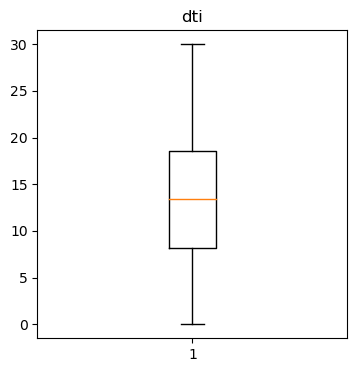

In [19]:
fig = plt.figure(figsize = (4,4))
plt.boxplot(loan['dti']) #this percent is not greater than 100 so its fine - no outliers also
plt.title('dti')

Text(0.5, 1.0, 'loan_amnt')

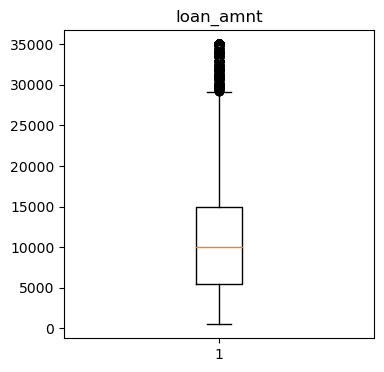

In [20]:
fig = plt.figure(figsize = (4,4))
plt.boxplot(loan['loan_amnt'])
plt.title('loan_amnt')

Text(0.5, 1.0, 'funded_amnt')

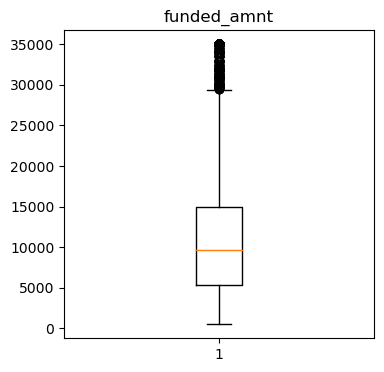

In [21]:
fig = plt.figure(figsize =(4, 4))
plt.boxplot(loan['funded_amnt'])
plt.title('funded_amnt')

Text(0.5, 1.0, 'int_rate')

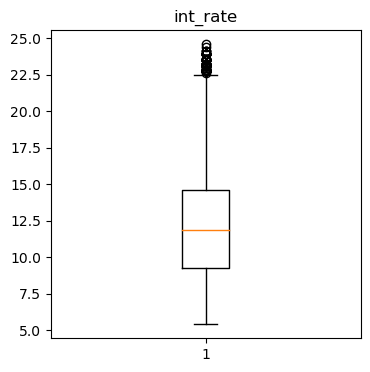

In [22]:
fig = plt.figure(figsize =(4, 4))
plt.boxplot(loan['int_rate'])
plt.title('int_rate')

Text(0.5, 1.0, 'annual_inc')

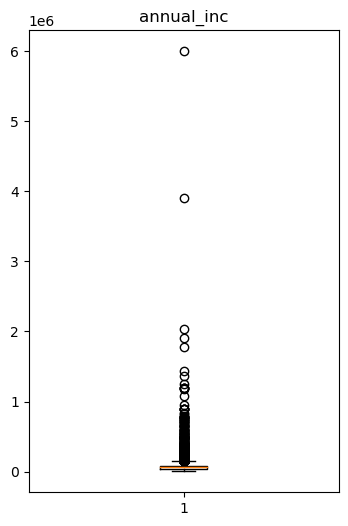

In [23]:
fig = plt.figure(figsize =(4, 6))
plt.boxplot(loan['annual_inc'])
plt.title('annual_inc')

Other columns data seems to be continuous but Annual income seems to have outliers. the outlier points seem to be above 4x10^6. here we can see the 95th percentile is also less than the outlier point so lets remove all the records above the 95th percentile

In [24]:
loan['annual_inc'].quantile([0.5,0.75,0.85,0.90,0.95])

0.50     59000.0
0.75     82300.0
0.85    100000.0
0.90    116000.0
0.95    142000.0
Name: annual_inc, dtype: float64

In [25]:
loan_95 = loan['annual_inc'].quantile(0.95)
loan = loan[loan['annual_inc']<= loan_95]

Text(0.5, 1.0, 'annual_inc')

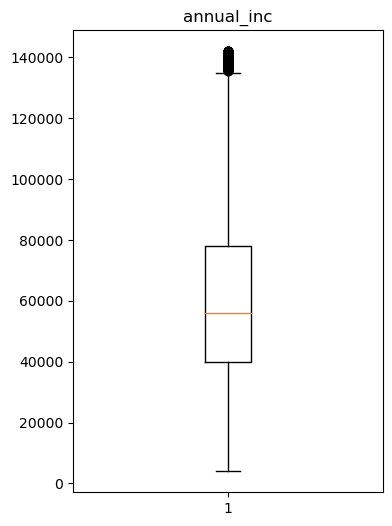

In [26]:
fig = plt.figure(figsize =(4, 6))
plt.boxplot(loan['annual_inc'])
plt.title('annual_inc')

## Data Analysis

### Debt-to-Income ratio
as described in data dictionary, A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.


The higher the dti the higher the risk for the lenders. lenders generally seek dti ratiio no more than 36%. lets check if there is any difference in the dti values between defaulters and fully paid users.

In [27]:
defaulters = loan[loan['loan_status'] == 'Charged Off']
paid_users = loan[loan['loan_status'] == 'Fully Paid']

In [28]:
defaulters['dti'].describe()

count    5421.000000
mean       14.105054
std         6.586108
min         0.000000
25%         9.180000
50%        14.400000
75%        19.400000
max        29.850000
Name: dti, dtype: float64

In [29]:
paid_users['dti'].describe()

count    31268.000000
mean        13.328965
std          6.668746
min          0.000000
25%          8.190000
50%         13.430000
75%         18.590000
max         29.990000
Name: dti, dtype: float64

In [30]:
defaulters['dti'].median()

14.4

In [31]:
paid_users['dti'].median()

13.43

Text(0.5, 1.0, 'influence of dti on loan defaulting')

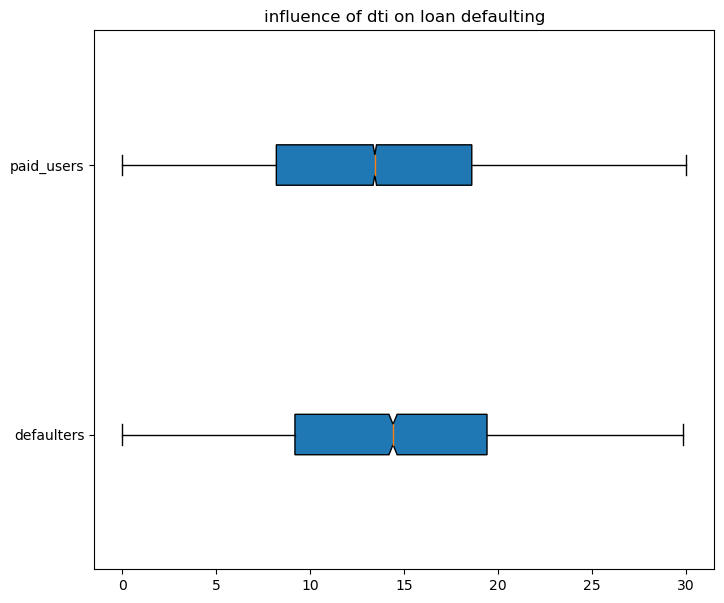

In [32]:
data = [defaulters['dti'],paid_users['dti']] 
fig = plt.figure(figsize =(8, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot(data, patch_artist = True, notch ='True', vert = 0)
ax.set_yticklabels(['defaulters', 'paid_users'])
plt.title("influence of dti on loan defaulting")

The median and mean seem to be closer to each other and there is no much difference between the average dti of paid users and defaulters. 

## Derived Columns
lets create some new columns that will help our analysis.

In [33]:
loan['monthly_income'] = (loan['annual_inc']/12).round(2)
defaulters['monthly_income'] = (defaulters['annual_inc']/12).round(2)
paid_users['monthly_income'] = (paid_users['annual_inc']/12).round(2)

In [34]:
loan['monthly_emis'] = loan['dti']*loan['annual_inc']/(100*12)#deriving monthly emi
loan['new_dti']=(loan['monthly_emis']+loan['installment'])*100/loan['monthly_income']
#calculating the new dti including the current loan installment

In [35]:
loan.groupby('loan_status')['new_dti'].mean()#we can see there is a difference between dti of charged off and fully paid

loan_status
Charged Off    21.624743
Current        22.576889
Fully Paid     19.920270
Name: new_dti, dtype: float64

we couldn't see much difference in dti column but the new_dti including the LC loan installment clearly shows the difference between Fully paid users and defaulters.

Now lets check the infuence of interest rate on default rate

In [36]:
def loan_group(x):
    if x < 5000:
        return str('0-5k')
    elif (x > 5000 and x < 10000):
        return str('5-10k')
    elif (x > 10000 and x <= 15000):
        return str('10-15k')
    elif (x > 15000 and x <= 20000):
        return str('15-20k')
    elif (x > 20000 and x <= 25000):
        return str('20-25k')
    elif (x > 25000 and x <= 30000):
        return str('25-30k')
    else:
        return str('30-25k')

In [37]:
defaulters['loan_group'] = defaulters['loan_amnt'].apply(loan_group)
defaulters.groupby('loan_group')['int_rate'].mean()

loan_group
0-5k      12.633527
10-15k    13.972286
15-20k    14.874758
20-25k    15.518598
25-30k    17.061301
30-25k    13.753688
5-10k     12.846709
Name: int_rate, dtype: float64

In [38]:
paid_users['loan_group'] = paid_users['loan_amnt'].apply(loan_group)
paid_users.groupby('loan_group')['int_rate'].mean()

loan_group
0-5k      10.920800
10-15k    11.701135
15-20k    12.766309
20-25k    13.674371
25-30k    14.972851
30-25k    11.355268
5-10k     10.913784
Name: int_rate, dtype: float64

It looks like interest rates for defaulters are higher than paid users, lets create a bar char to visualize.

In [39]:
loan['loan_group'] = loan['loan_amnt'].apply(loan_group)
lt = pd.DataFrame()
lt['loan_group'] = loan['loan_group'].unique()
lt['defaulters'] = np.array(defaulters.groupby('loan_group')['int_rate'].mean())
lt['paid_users']= np.array(paid_users.groupby('loan_group')['int_rate'].mean())

<Axes: xlabel='loan_group'>

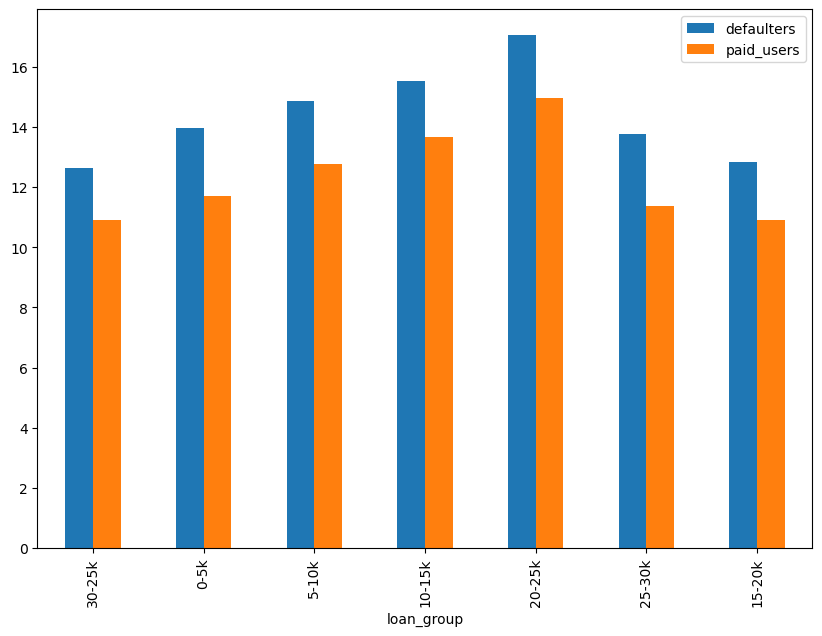

In [40]:
lt.plot(x='loan_group', y=['defaulters','paid_users'], kind='bar', figsize=(10,7))


We can clearly see that the interest rates have been higher for the defaulted loans consistenlty for all the loan amount ranges

## Categorical Variables

Lets see if we can find any difference in the distribution of defaulters and paid users through categorical variables

Text(0.5, 1.0, 'home_ownership distribution in defaulters')

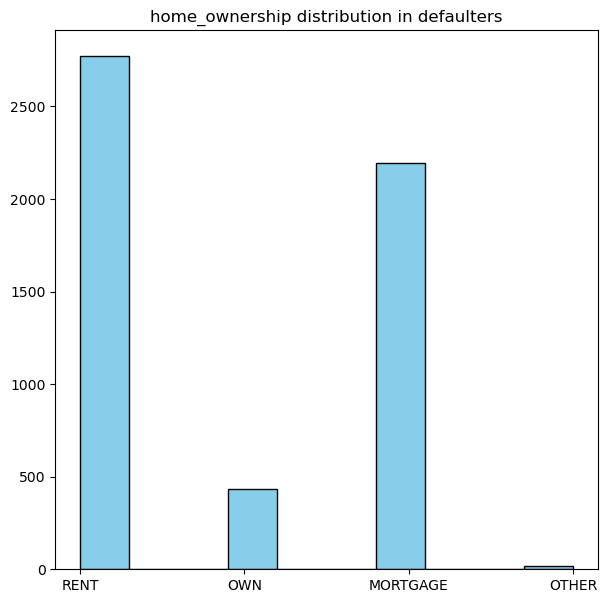

In [41]:
fig = plt.figure(figsize=(7,7))
plt.hist(defaulters['home_ownership'], color='skyblue', edgecolor='black')
plt.title("home_ownership distribution in defaulters")

Text(0.5, 1.0, 'home_ownership distribution in Fully paid users')

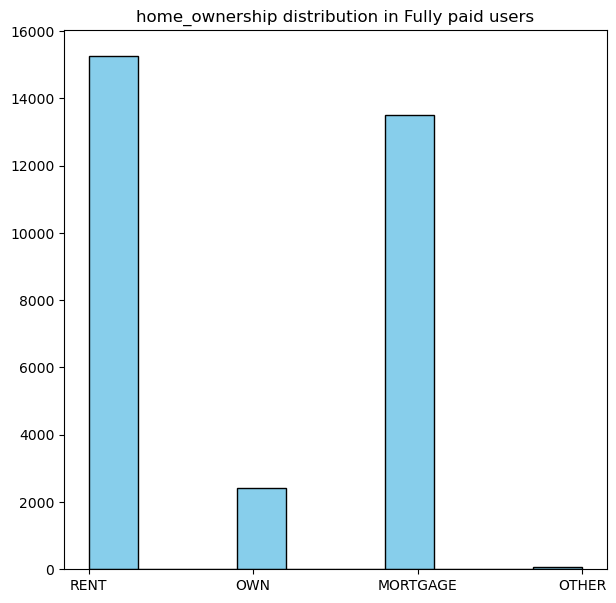

In [42]:
fig = plt.figure(figsize =(7, 7))
plt.hist(paid_users['home_ownership'], color='skyblue', edgecolor='black')
plt.title("home_ownership distribution in Fully paid users")

The distribution looks similar, so we can rule out the possibility of hoe ownership effecting the defaulting rate

Text(0.5, 1.0, 'emp_length distribution in Fully paid users')

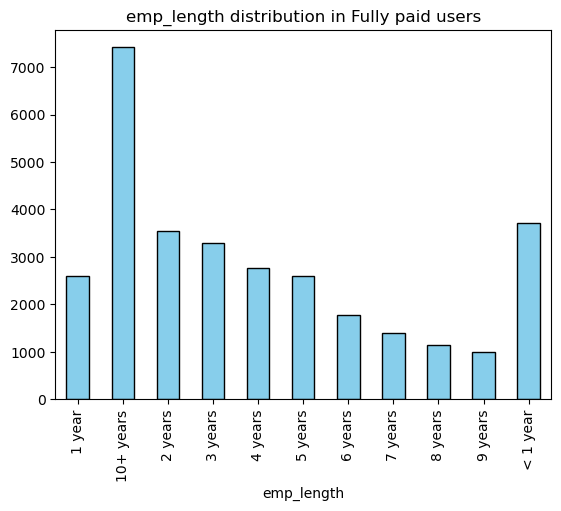

In [43]:
paid_users.groupby(['emp_length'])['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')
plt.title("emp_length distribution in Fully paid users")

Text(0.5, 1.0, 'emp_length distribution in defaulters')

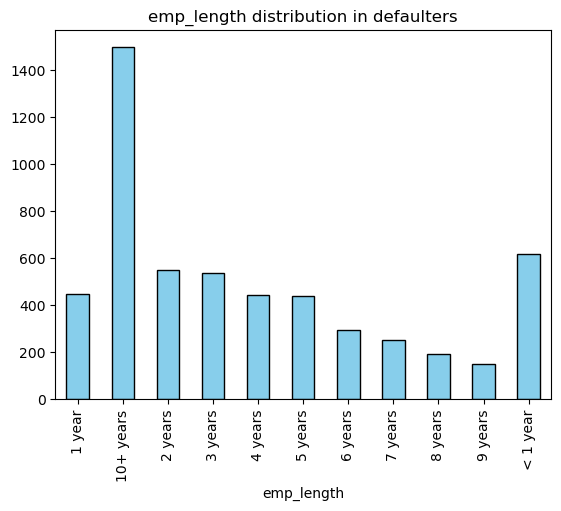

In [44]:
defaulters.groupby(['emp_length'])['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')
plt.title("emp_length distribution in defaulters")

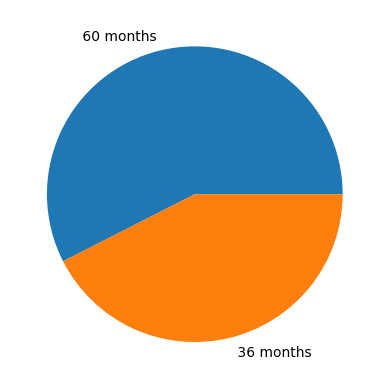

In [45]:
y=(defaulters['term'].value_counts()/defaulters['term'].count())*100

plt.pie(y, labels=defaulters['term'].unique())
plt.show() 

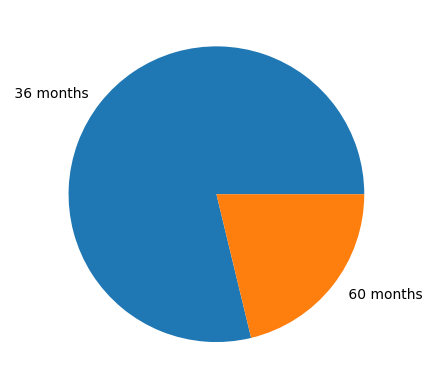

In [46]:
y=(paid_users['term'].value_counts()/paid_users['term'].count())*100

plt.pie(y, labels=paid_users['term'].unique())
plt.show() 

We can clearly see that loans with 60 months as term have a high chance of defaulting while most paid loans are with 36 months as term.

<Axes: xlabel='purpose'>

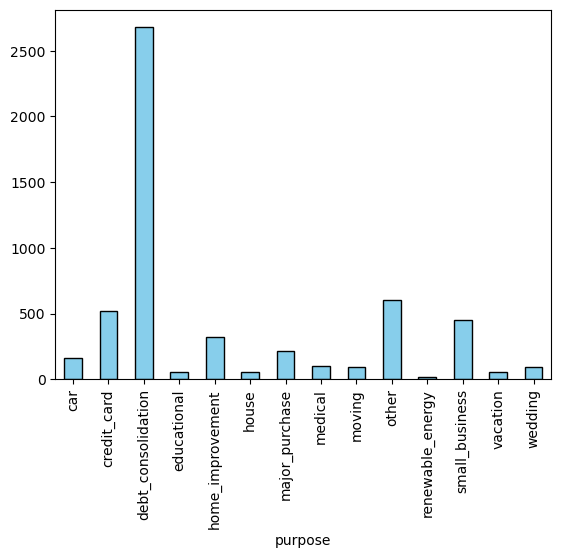

In [47]:
defaulters.groupby('purpose')['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')

<Axes: xlabel='purpose'>

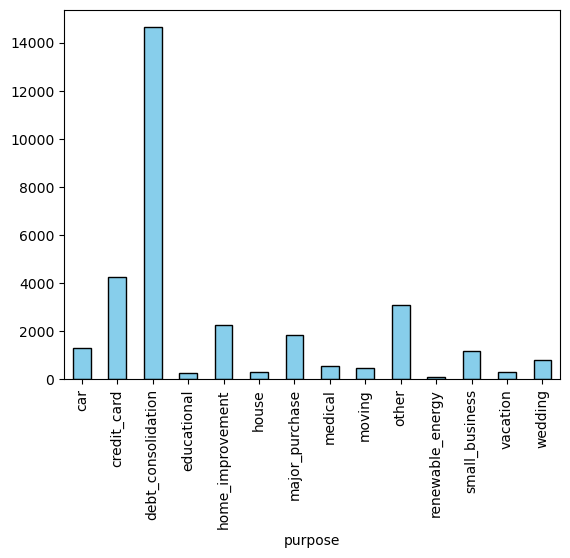

In [48]:
paid_users.groupby('purpose')['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')

The distribution seems similar, so purpose is not an indicator of loan defaulting

Analysis for delinq_2yrs( number of 30+ days past-due incidences of delinquency) column is based on the two charts given below. 

Text(0.5, 1.0, 'delinq_2yrs distribution in defaulters')

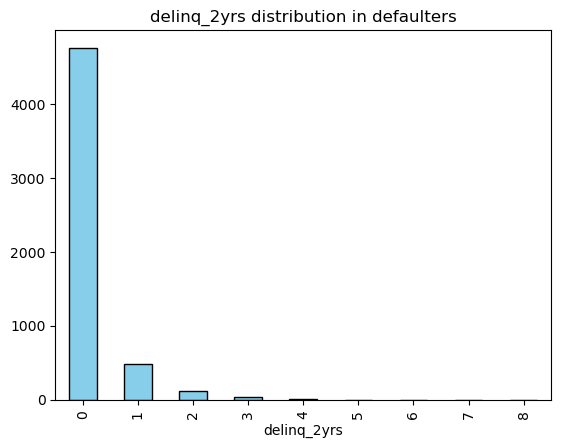

In [49]:
defaulters.groupby('delinq_2yrs')['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')
plt.title('delinq_2yrs distribution in defaulters')

Text(0.5, 1.0, 'delinq_2yrs distribution in paid users')

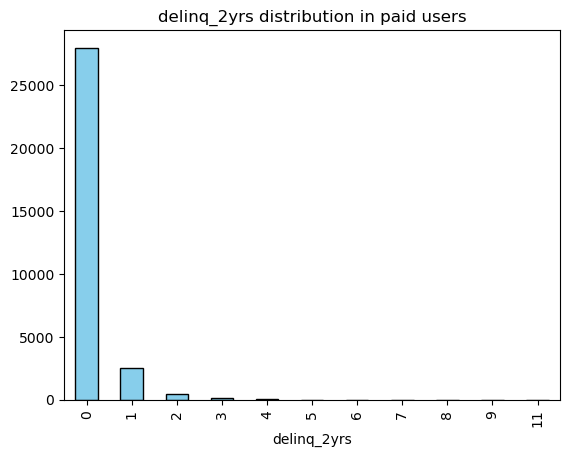

In [50]:
paid_users.groupby('delinq_2yrs')['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')
plt.title('delinq_2yrs distribution in paid users')

Above analysis of delinq_2yrs( number of 30+ days past-due incidences of delinquency) shows that there is not much difference in the above charts for defaulters vs paid users. Thus delinq_2yrs does not have much impact.

Analysis for inq_last_6mths (inquiries in past 6 months) column is based on the two charts given below. 

Text(0.5, 1.0, 'inq_last_6mths distribution in defaulters')

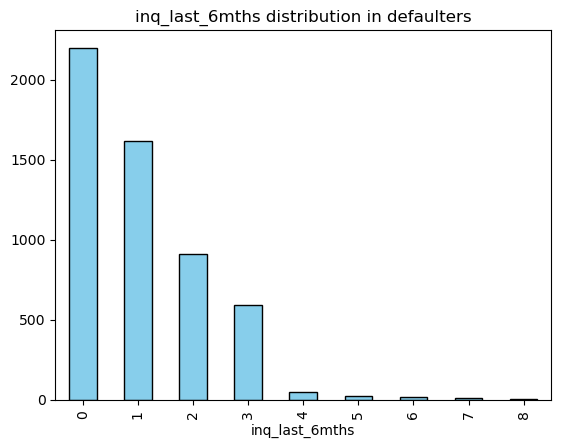

In [51]:
defaulters.groupby('inq_last_6mths')['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')
plt.title('inq_last_6mths distribution in defaulters')

Text(0.5, 1.0, 'inq_last_6mths distribution in paid users')

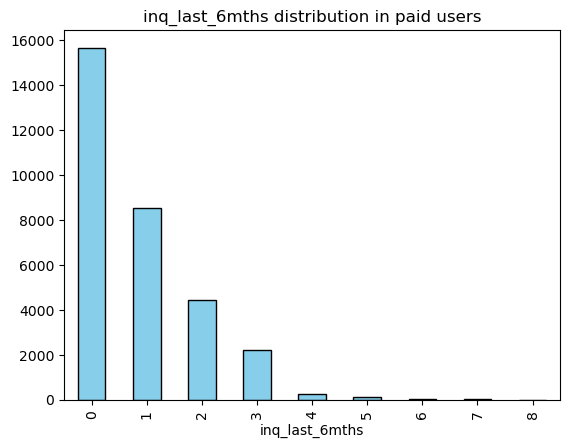

In [52]:
paid_users.groupby('inq_last_6mths')['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')
plt.title('inq_last_6mths distribution in paid users')

Above analysis of inq_last_6mths (inquiries in past 6 months) shows that there is not much difference in the above charts for defaulters vs paid users. Thus inq_last_6mths does not have much impact.

Analysis for pub_rec_bankruptcies column is based on the two charts given below. 

Text(0.5, 1.0, 'pub_rec_bankruptcies distribution in defaulters')

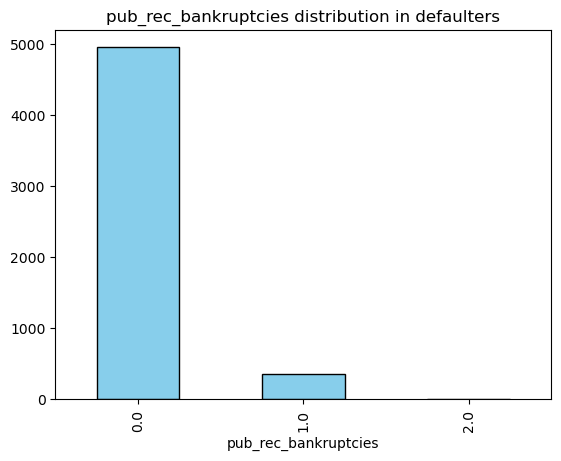

In [53]:
defaulters.groupby('pub_rec_bankruptcies')['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')
plt.title('pub_rec_bankruptcies distribution in defaulters')

Text(0.5, 1.0, 'pub_rec_bankruptcies distribution in paid users')

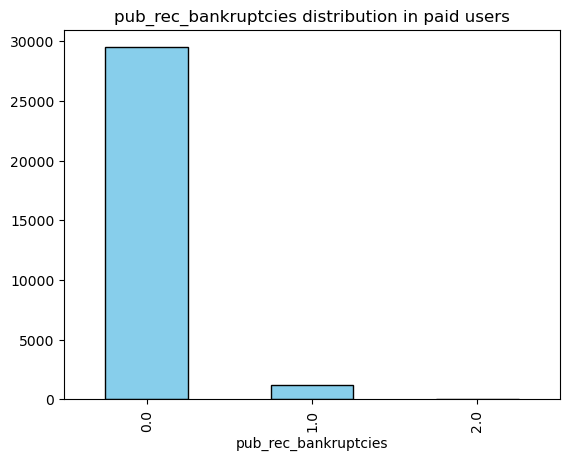

In [54]:
paid_users.groupby('pub_rec_bankruptcies')['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')
plt.title('pub_rec_bankruptcies distribution in paid users')

Above analysis of pub_rec_bankruptcies shows that pub_rec_bankruptcies does not have much impact on whether a borrower is going to default or not.

Below is the analysis of the column pub_rec.

Text(0.5, 1.0, 'pub_rec distribution in defaulters')

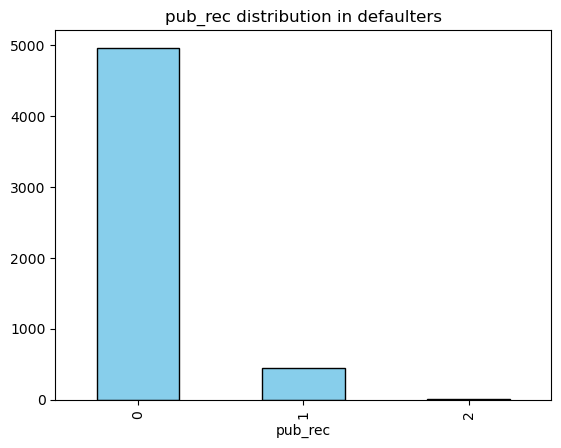

In [55]:
defaulters.groupby('pub_rec')['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')
plt.title('pub_rec distribution in defaulters')

Text(0.5, 1.0, 'pub_rec distribution in paid users')

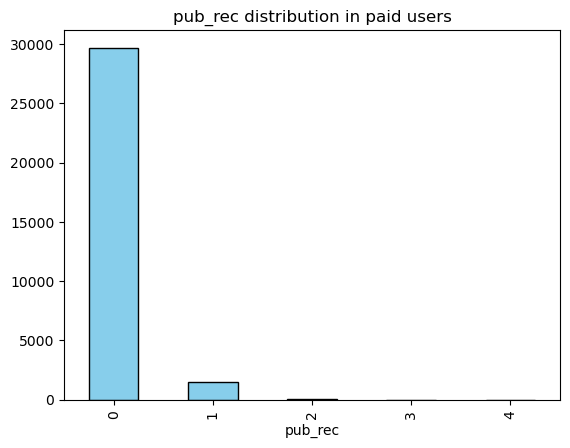

In [56]:
paid_users.groupby('pub_rec')['id'].count().plot(kind='bar',color='skyblue', edgecolor='black')
plt.title('pub_rec distribution in paid users')

Above analysis of pub_rec (Number of derogatory public records) shows that it does not have much impact on whether a borrower is going to default or not.

Text(0.5, 1.0, 'revol_util distribution in defaulters')

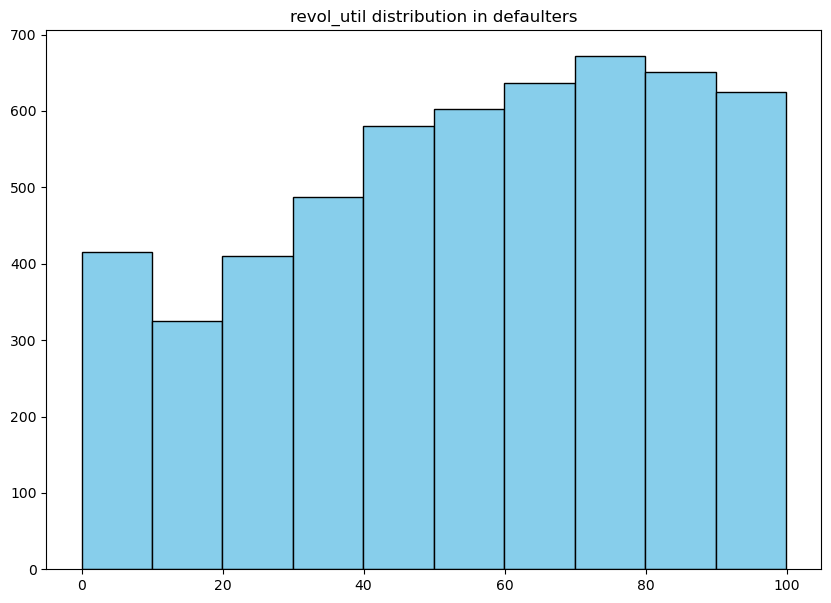

In [57]:
fig = plt.figure(figsize =(10, 7))
plt.hist(defaulters['revol_util'], color='skyblue', edgecolor='black')
plt.title("revol_util distribution in defaulters")

Text(0.5, 1.0, 'revol_util distribution in paid users')

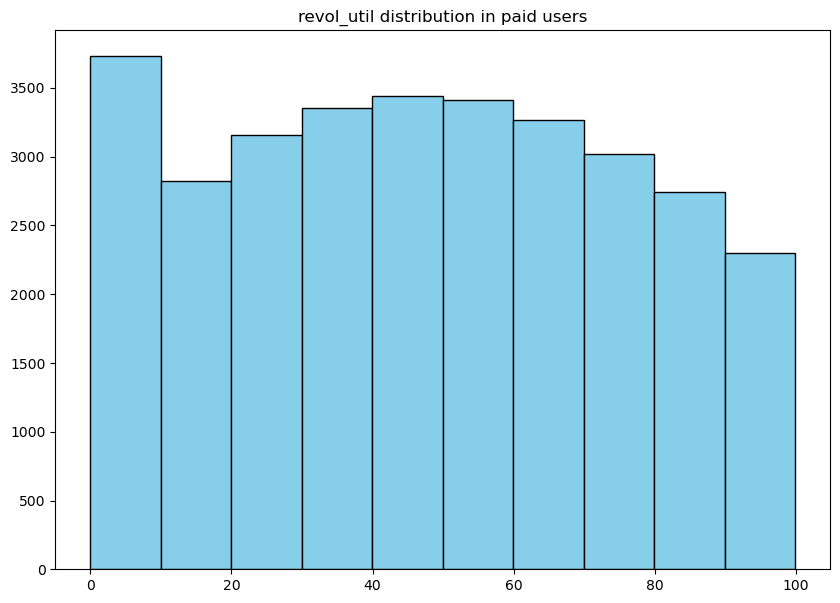

In [58]:
fig = plt.figure(figsize =(10, 7))
plt.hist(paid_users['revol_util'], color='skyblue', edgecolor='black')
plt.title("revol_util distribution in paid users")

Not very stark difference in the revol_util (revolving line utilization rate) distribution for defaulters vs paid users though defaulters are more when its value is on the higher side.

Text(0.5, 1.0, 'total_acc distribution in defaulters')

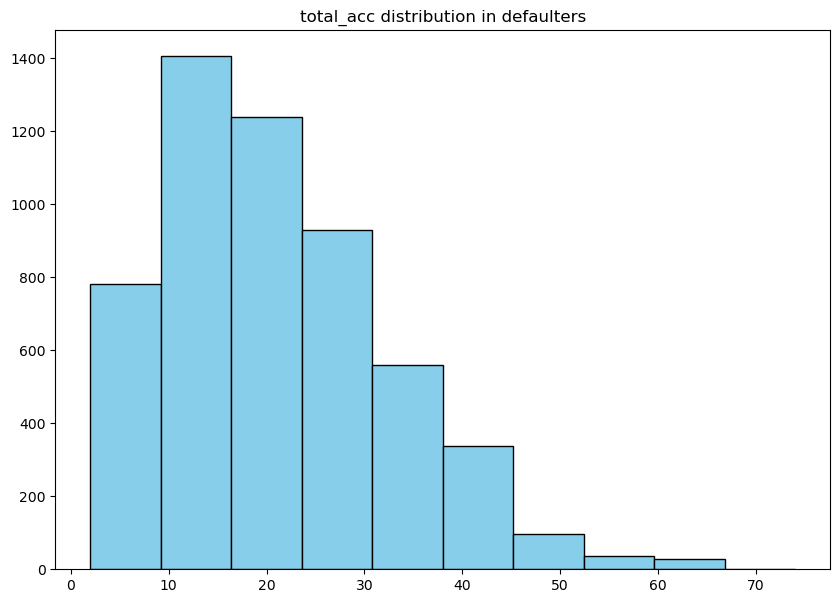

In [59]:
fig = plt.figure(figsize =(10, 7))
plt.hist(defaulters['total_acc'], color='skyblue', edgecolor='black')
plt.title("total_acc distribution in defaulters")

Text(0.5, 1.0, 'total_acc distribution in paid users')

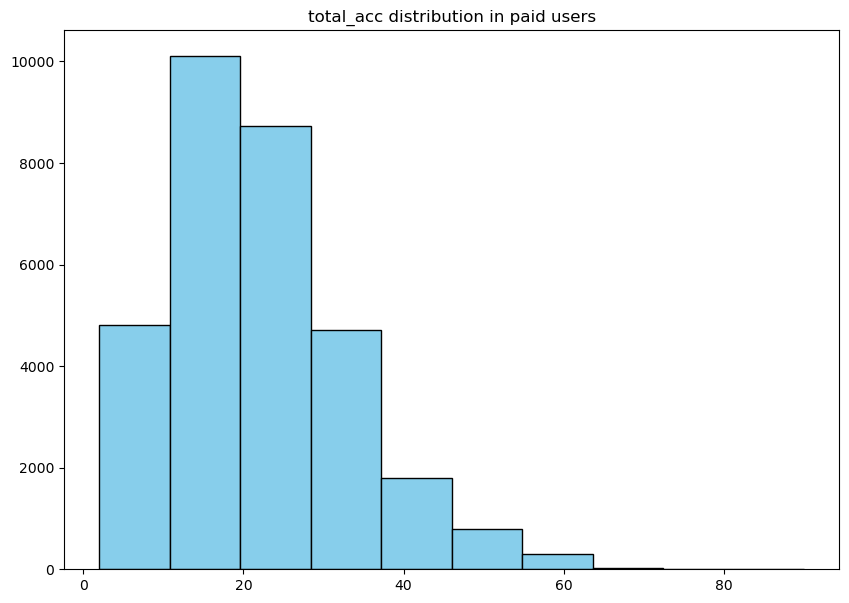

In [60]:
fig = plt.figure(figsize =(10, 7))
plt.hist(paid_users['total_acc'], color='skyblue', edgecolor='black')
plt.title("total_acc distribution in paid users")

The distrubution of values for column total_acc (total credit lines) in defaulters vs paid users is similar. This this column does not have an impact on decideing the possibility whether a borrow is going to default or not.

Text(0.5, 1.0, 'grade distribution in defaulters')

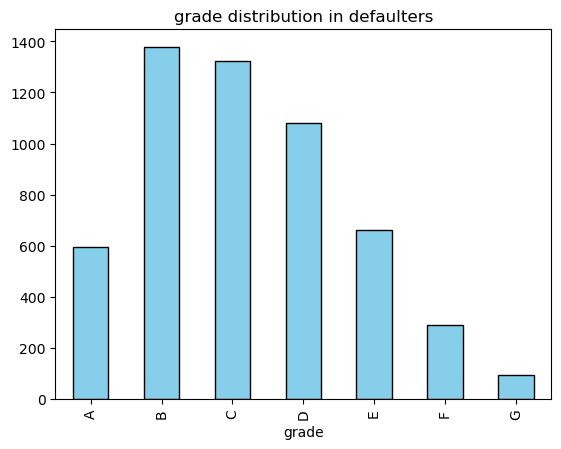

In [61]:
defaulters.groupby('grade')['id'].count().plot(kind = 'bar',color='skyblue', edgecolor='black')
plt.title('grade distribution in defaulters')

Text(0.5, 1.0, 'grade distribution in paid users')

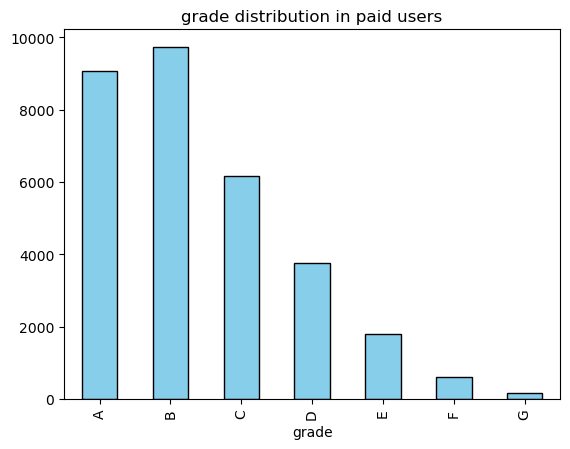

In [62]:
paid_users.groupby('grade')['id'].count().plot(kind = 'bar',color='skyblue', edgecolor='black')
plt.title('grade distribution in paid users')

In [63]:
grade_total_count=np.array(loan.groupby(['grade'])['id'].count())
grade_defaulters_count=np.array(defaulters.groupby('grade')['id'].count())
grade_paid_count=np.array(paid_users.groupby('grade')['id'].count())
grade_percent_defaulters=np.round((grade_defaulters_count/grade_total_count)*100)
print("Percentage of Defaulters in Grades A,B,C,D,E,F,G respectively is given below \n",grade_percent_defaulters)
grade_percent_paid=np.round((grade_paid_count/grade_total_count)*100)
print("Percentage of Paid Users in Grades A,B,C,D,E,F,G respectively is given below \n",grade_percent_paid)

Percentage of Defaulters in Grades A,B,C,D,E,F,G respectively is given below 
 [ 6. 12. 17. 21. 25. 31. 34.]
Percentage of Paid Users in Grades A,B,C,D,E,F,G respectively is given below 
 [93. 85. 80. 74. 68. 63. 61.]


The above bar charts  and percentages shows that grade A has very less chance of defaulting where as grades C,D,E,F have comparatively higher chances of defaulting.